<a href="https://colab.research.google.com/github/danshal/DL_project/blob/develop/wav2vec_SV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Install fairseq and more packages

In [4]:
!pip install soundfile git+git://github.com/pytorch/fairseq.git@b8ea8a9b72c82192da07e3377adf4ebbde16716d
!pip install fairseq
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
#!mkdir fairseq_code
#%cd /content/drive/MyDrive/DeepProject/wav2vec/fairseq_code/
#!git clone https://github.com/pytorch/fairseq.git

  Cloning git://github.com/pytorch/fairseq.git (to revision b8ea8a9b72c82192da07e3377adf4ebbde16716d) to /tmp/pip-req-build-wgn0rnm8
  Running command git clone -q git://github.com/pytorch/fairseq.git /tmp/pip-req-build-wgn0rnm8
  Running command git checkout -q b8ea8a9b72c82192da07e3377adf4ebbde16716d
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for fairseq: filename=fairseq-1.0.0a0+b8ea8a9-cp36-cp36m-linux_x86_64.whl size=2731763 sha256=884fb14e405c83fd6e4e3c30162e7429edd7b9f1f185a3703609dbc69eb60955
  Stored in directory: /tmp/pip-ephem-wheel-cache-aqlwj4e4/wheels/39/26/93/08a9f837c7e94436027d116b1ffe57822725b2caf742649fb3
Successfully built fairseq


##Imports

In [76]:
#General imports
import argparse
import glob
import os
import os.path as osp
import pprint
import soundfile as sf
from typing import Tuple
#facebook team framework
import fairseq
#pytorch
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import torchaudio
from torch import Tensor
from torch.utils.data import Dataset
from torchaudio.datasets.utils import (
    download_url,
    extract_archive,
    walk_files,
)

#matplotlib
import matplotlib.pyplot as plt
#numpy
import numpy as np
#pandas
import pandas as pd
try:
    import tqdm
except:
    print("Install tqdm to use --log-format=tqdm")



In [2]:
import torch
print(torch.__version__)
!nvcc --version
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.is_available())

1.7.1+cu101
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
cuda
True


##Get Trained Model & Try Sanity Code

In [12]:
cp_path = cp_path = '/content/drive/My Drive/DeepProject/wav2vec/wav2vec_large.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0]
model.eval()

wav_input_16khz = torch.randn(1,10000)
z = model.feature_extractor(wav_input_16khz)
c = model.feature_aggregator(z)
print(f'input shape = {wav_input_16khz.shape} ; z shape = {z.shape} ; z shape = {c.shape}')

input shape = torch.Size([1, 10000]) ; z shape = torch.Size([1, 512, 60]) ; z shape = torch.Size([1, 512, 60])


In [160]:
#@title Hyperparametes
batch_size = 32
epochs = 100


###Download Dataset
###Information about LibriSpeech dataset:
1. Total of 982 hours of 16KHz read English speech
2. 2484 speakers in this corpus.
3. Suppose to be reasonably balances in terms of gender and per-speaker duration
4. Allowed urls for LIBRISPEECH - "dev-clean", "dev-other", "test-clean", "test-other", "train-clean-100", "train-clean-360" and "train-other-500". (default: "train-clean-100")

In [ ]:
# rootDir = '/content/drive/MyDrive/DeepProject/wav2vec/'
# # Download training data
# train_data = torchaudio.datasets.LIBRISPEECH(f'{rootDir}/dataset/', download=True)
# # Download test data
# test_data = torchaudio.datasets.LIBRISPEECH(f'{rootDir}/dataset/', url='test-clean', download=True)

##Helper Functions

In [19]:
def read_audio(fname):
    ''' Load an audio file and return PCM along with the sample rate '''

    wav, sr = sf.read(fname)
    assert sr == 16e3

    return wav, 16e3


def audio2tensor(fname):
  ''' This function will convert audio samples to tensor '''
  input, _ = read_audio(fname)
  input_tensor = torch.from_numpy(input).float()
  return input_tensor.reshape(1, input_tensor.size(0))


def get_audio_repr(fname):
  ''' This function will get audio as input and will output its representation
      as wav2vec model outputs '''
  input_tensor = audio2tensor(fname)
  z = model.feature_extractor(input_tensor)
  c = model.feature_aggregator(z)
  return c


def get_tensor_repr(input_tensor):
  '''This function will get a tensor and return its representation as wav2vec
     model outputs'''
  with torch.no_grad():
    z = model.feature_extractor(input_tensor)
    c = model.feature_aggregator(z)
    return c


def get_sv_example_generator(data):
  '''This function gets data that loaded as LIBRISPEECH dataset and yields its
     wav2vec tensor representation with the speaker id''' 
  train_data_iter = iter(data)
  for i in train_data_iter:
    yield [get_tensor_repr(i[0]), i[3]]

##Make My Own Dataset Class

In [161]:
rootDir = '/content/drive/MyDrive/DeepProject/wav2vec/'
URL = "train-clean-100"
FOLDER_IN_ARCHIVE = "SV_Librispeech_Dataset"
FOLDER_IN_ARCHIVE_ORIGINAL_LIBRI = "LibriSpeech"
_CHECKSUMS = {
    "http://www.openslr.org/resources/12/dev-clean.tar.gz":
    "76f87d090650617fca0cac8f88b9416e0ebf80350acb97b343a85fa903728ab3",
    "http://www.openslr.org/resources/12/dev-other.tar.gz":
    "12661c48e8c3fe1de2c1caa4c3e135193bfb1811584f11f569dd12645aa84365",
    "http://www.openslr.org/resources/12/test-clean.tar.gz":
    "39fde525e59672dc6d1551919b1478f724438a95aa55f874b576be21967e6c23",
    "http://www.openslr.org/resources/12/test-other.tar.gz":
    "d09c181bba5cf717b3dee7d4d592af11a3ee3a09e08ae025c5506f6ebe961c29",
    "http://www.openslr.org/resources/12/train-clean-100.tar.gz":
    "d4ddd1d5a6ab303066f14971d768ee43278a5f2a0aa43dc716b0e64ecbbbf6e2",
    "http://www.openslr.org/resources/12/train-clean-360.tar.gz":
    "146a56496217e96c14334a160df97fffedd6e0a04e66b9c5af0d40be3c792ecf",
    "http://www.openslr.org/resources/12/train-other-500.tar.gz":
    "ddb22f27f96ec163645d53215559df6aa36515f26e01dd70798188350adcb6d2"
}


size = (100, 100)
#filter options for tranform are:
#1. PIL.Image.NEAREST -> Pick one nearest pixel from the input image. Ignore all other input pixels.
#2. PIL.Image.BILINEAR -> For resize calculate the output pixel value using linear interpolation on all pixels that may contribute to the output value. For other transformations linear interpolation over a 2x2 environment in the input image is used.
#3. PIL.Image.HAMMING -> Produces a sharper image than BILINEAR, doesn’t have dislocations on local level like with BOX.
#4. PIL.Image.BICUBIC -> For resize calculate the output pixel value using cubic interpolation on all pixels that may contribute to the output value. For other transformations cubic interpolation over a 4x4 environment in the input image is used.
#5. PIL.Image.LANCZOS -> Calculate the output pixel value using a high-quality Lanczos filter (a truncated sinc) on all pixels that may contribute to the output value
#For more details -> https://pillow.readthedocs.io/en/latest/handbook/concepts.html#filters
transform = transforms.Resize(size)


def load_sv_librispeech_item(fileid: str, path: str, ext_audio: str,
                          wav2vec_fine_tuning: bool) -> Tuple[Tensor, int]:
    '''This function will get path to audio file and will return a list of
       this audio representation as wav2vec model produces with the speaker_id
       Updata -> returning wav2vec is too heavy and causes runtime reset!
       Maybe working with google VM will solve this issue.'''
    speaker_id, utterance_id = fileid.split("-")
    #fileid_audio = speaker_id + "-" + chapter_id + "-" + utterance_id
    fileid_audio = speaker_id + "-" + utterance_id
    file_audio = fileid_audio + ext_audio
    file_audio = os.path.join(path, speaker_id, file_audio)
    waveform, _ = torchaudio.load(file_audio) # Load audio - dont care about sample rate
    if wav2vec_fine_tuning == False:
      waveform_repr = get_tensor_repr(waveform)
      return (waveform_repr, int(speaker_id))
    return (waveform, int(speaker_id))
    #with torch.no_grad():
      #transformed_waveform_repr = transform(waveform_repr)
    #return transformed_waveform_repr, int(speaker_id)
    
    #return (waveform, int(speaker_id))


# create my own collate function to avoid stacking same size examples in a batch
def my_collate(batch):
    data = [item[0] for item in batch]  #get 512 X ? tensor in item[0]
    data = tuple(data)
    data = torch.cat(data)
    data = torch.tensor(data, dtype=torch.float)
    target = [item[1] for item in batch]        
    target = torch.LongTensor(target)
    return [data, target]


class SV_LIBRISPEECH(Dataset):
    """Create a Dataset for SV_LibriSpeech.

    Args:
        root (str): Path to the directory where the dataset is found or downloaded.
        url (str, optional): The URL to download the dataset from,
            or the type of the dataset to dowload.
            Allowed type values are ``"dev-clean"``, ``"dev-other"``, ``"test-clean"``,
            ``"test-other"``, ``"train-clean-100"``, ``"train-clean-360"`` and
            ``"train-other-500"``. (default: ``"train-clean-100"``)
        folder_in_archive (str, optional):
            The top-level directory of the dataset. (default: ``"LibriSpeech"``)
        download (bool, optional):
            Whether to download the dataset if it is not found at root path. (default: ``False``).
    """

    _ext_audio = ".flac"

    def __init__(self, root: str, url: str = URL,
                 folder_in_archive: str = FOLDER_IN_ARCHIVE,
                 download: bool = False, is_SV: bool = True, wav2vec_fine_tuning: bool = False) -> None:

        if url in [
            "dev-clean",
            "dev-other",
            "test-clean",
            "test-other",
            "train-clean-100",
            "train-clean-360",
            "train-other-500",
        ]:
            ext_archive = ".tar.gz"
            base_url = "http://www.openslr.org/resources/12/"

            url = os.path.join(base_url, url + ext_archive)

        basename = os.path.basename(url)
        archive = os.path.join(root, basename)

        basename = basename.split(".")[0]
        if is_SV == False:
          folder_in_archive = os.path.join(folder_in_archive, basename)

        self._path = os.path.join(root, folder_in_archive)

        if download:
            if not os.path.isdir(self._path):
                if not os.path.isfile(archive):
                    checksum = _CHECKSUMS.get(url, None)
                    download_url(url, root, hash_value=checksum)
                extract_archive(archive)
        
        walker = walk_files(self._path, suffix=self._ext_audio, prefix=False, remove_suffix=True)
        self._walker = list(walker)
        self.ft = wav2vec_fine_tuning
  

    def __getitem__(self, n: int) -> Tuple[Tensor, int]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            tuple: ``(waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id)``
        """
        fileid = self._walker[n]  #get file name without .flac suffix        
        #librispeech_item, speaker_id = load_sv_librispeech_item(fileid, self._path, self._ext_audio)

        return load_sv_librispeech_item(fileid, self._path, self._ext_audio, self.ft)

    def __len__(self) -> int:
        return len(self._walker)


my_train_data = SV_LIBRISPEECH('/content/drive/MyDrive/DeepProject/wav2vec/', wav2vec_fine_tuning = False)
print(len(my_train_data))
my_train_loader = torch.utils.data.DataLoader(my_train_data, batch_size=batch_size, shuffle=True, collate_fn=my_collate)

1606


##Write list of audio lengths to a file

In [98]:
from tabulate import tabulate
x = list(range(25))
l = [0, 24, 563, 683, 670, 620, 636, 661, 722, 785, 975, 1379, 2491, 4074, 6012, 6428, 1763, 49, 1, 2, 0, 0, 0, 0, 1]
table_data = [x, l]
print(tabulate(table_data, headers='firstrow', tablefmt='fancy_grid'))
#write it to a file
with open('histogram.txt', 'w') as f:
  f.write(tabulate(table_data, headers='firstrow', tablefmt='fancy_grid'))

╒═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╕
│   0 │   1 │   2 │   3 │   4 │   5 │   6 │   7 │   8 │   9 │   10 │   11 │   12 │   13 │   14 │   15 │   16 │   17 │   18 │   19 │   20 │   21 │   22 │   23 │   24 │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╡
│   0 │  24 │ 563 │ 683 │ 670 │ 620 │ 636 │ 661 │ 722 │ 785 │  975 │ 1379 │ 2491 │ 4074 │ 6012 │ 6428 │ 1763 │   49 │    1 │    2 │    0 │    0 │    0 │    0 │    1 │
╘═════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╛


##Just checking it worked

In [163]:
#print(next(iter(my_train_loader)))
counter = 0
for i, data in enumerate(my_train_loader, 0):
  counter = counter + 1
  if counter > 3:
    break
  inputs, labels = data[0].to(device), data[1].to(device)
  print(inputs[0].shape)
  print(inputs[1].shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([512, 298])
torch.Size([512, 298])
torch.Size([512, 298])
torch.Size([512, 298])
torch.Size([512, 298])
torch.Size([512, 298])


##Check size of preprocessed data

In [108]:
a, s1 = torchaudio.load('/content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Dataset/1088/5.flac')
b, s2 = torchaudio.load('/content/drive/MyDrive/DeepProject/wav2vec/SV_Librispeech_Dataset/1088/6.flac')
print(a.shape, s1)
print(b.shape, s2)

MyDrive  Shareddrives
torch.Size([1, 48000]) 16000
torch.Size([1, 48000]) 16000


##Show Training Examples

In [162]:
exmps = next(iter(my_train_data))
count = 0
for i in iter(my_train_data):
  count = count + 1
  print(i)
  if count == 2:
    break
print(exmps[0].shape)  #audio samples as tensor
print(exmps[1])  #represents speaker id

(tensor([[[1.1117e-02, 1.1208e-02, 1.5232e-02,  ..., 1.9779e-02,
          3.3761e-02, 3.6744e-02],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 6.2024e-03],
         [3.4431e-02, 4.2196e-02, 7.5523e-02,  ..., 0.0000e+00,
          7.4715e-03, 7.1994e-03],
         ...,
         [2.9838e-04, 0.0000e+00, 8.9853e-04,  ..., 0.0000e+00,
          0.0000e+00, 1.1920e-03],
         [2.7779e-01, 2.4062e-01, 2.4504e-01,  ..., 1.6338e-01,
          1.6800e-01, 1.7845e-01],
         [5.9156e-04, 2.6030e-04, 0.0000e+00,  ..., 3.3415e-01,
          3.8136e-01, 3.5824e-01]]]), 103)
(tensor([[[0.0053, 0.0044, 0.0099,  ..., 0.0233, 0.0198, 0.0234],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0034, 0.0044, 0.0050],
         ...,
         [0.0061, 0.0062, 0.0073,  ..., 0.0294, 0.0441, 0.0276],
         [0.0795, 0.0917, 0.0316,  ..., 0.0273, 0.0450, 0.0153],
         [0.1715, 0.2008, 0.1697,  ..., 0.2

Shape of waveform: torch.Size([1, 108800])
Sample rate of waveform: 16000


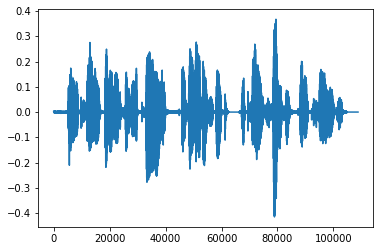

In [ ]:
waveform, sample_rate = torchaudio.load(f'{speaker_84_data_dir}/121123/84-121123-0003.flac')

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

###Get information about audio file include the duration time in seconds

In [ ]:
print(sf.info(f'{speaker_84_data_dir}/121123/84-121123-0003.flac'))

/content/drive/MyDrive/DeepProject/wav2vec/LibriSpeech/dev-clean/84/121123/84-121123-0003.flac
samplerate: 16000 Hz
channels: 1
duration: 6.800 s
format: FLAC (Free Lossless Audio Codec) [FLAC]
subtype: Signed 16 bit PCM [PCM_16]


##On Top Model

In [ ]:
class NAIVE_SV(nn.Module):
  

##Declare Loss functions and some Hyperparametes

##Generic Training Code